In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

/Users/MP/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<h3>Business Analytics: We have provided a sample of 460 games (230 from the 2016-17 season and 230 from the 2017-18 season) for which your task is to predict total international viewers. To assist with your model, we have provided viewership numbers from 1,000 games by country in each of the two seasons, plus stats on team and player performance and status. Using these inputs, we would like you to predict the total number of international viewers for each of the 460 games in the test set.</h3>

<em>You will be graded on Mean Absolute Percentage Error (MAPE) on Total Viewers. We selected this metric due to natural scaling in the international viewership data. Further details on each source file and on the MAPE evaluation metric are provided in the prompt PDF made available here. Please return to us a copy of testset[Team_Name].csv with the “Total Viewers” column filled in with your response variable. Please note that each question is permitted a maximum of two file attachments. Please save your answer in a .csv file and save your code, spreadsheets and all other work in a zip file.</em>

<a href="https://nba.app.box.com/s/1qdbusoz1fmp1uxd4634zxxoudyv3ogc">LINK TO PROMPT .PDF</a>

In [2]:
# File Names
gameCSV = "game_data.csv"
playerCSV = "player_data.csv"
testCSV = "test_set.csv"
trainingCSV = "training_set.csv"

In [3]:
# Importing CSV Files
gameData = pd.read_csv("game_data.csv")
dfGameData = pd.DataFrame(gameData)

playerData = pd.read_csv("player_data.csv")
dfPlayerData = pd.DataFrame(playerData)

trainingSet = pd.DataFrame(pd.read_csv(trainingCSV))
testSet = pd.DataFrame(pd.read_csv(testCSV))

In [4]:
# Convert DateTime
dfGameData["Game_Date"] = pd.to_datetime(dfGameData["Game_Date"], infer_datetime_format=True)
dfPlayerData["Game_Date"] = pd.to_datetime(dfPlayerData["Game_Date"], infer_datetime_format=True)
trainingSet["Game_Date"] = pd.to_datetime(trainingSet["Game_Date"], infer_datetime_format=True)

# Remove Spaces from column names
trainingSet.rename(columns={"Rounded Viewers":"Viewers"}, inplace=True)

About 18-19% of the games are missing data. 
Lets save a dataframe that drops those.

In [5]:
dfGameDataNoNA = dfGameData.dropna(how='any')
print("Games in data with NAs: %d" % len(dfGameData))
print("Games in clean data: %d" % len(dfGameDataNoNA))

Games in data with NAs: 4920
Games in clean data: 4000


Looking at the different standard deviations, the variation in L2M scoring, 4Q Scoring will have a good measure.
Also, let's make the assumption that better teams are going to have more viewers

In [6]:
dfGameData.std()

Game_ID               50006.342937
Wins_Entering_Gm         13.678415
Losses_Entering_Gm       13.648129
Team_Minutes              7.098147
Final_Score              12.196321
Lead_Changes              2.840888
Ties                      2.427680
Largest_Lead              9.094207
Full_Timeouts             1.168729
Short_Timeouts            0.909046
Qtr_4_Score              10.376985
L2M_Score                11.714484
dtype: float64

### Multi-Colinearity Check
Highest colinearity looks like its going to be on the overall scoring, which makes sense, more scoring in 4Q means total score is likely to be higher. Same with full timeouts are probably down in blowouts.
The general lack of correation may make it a little harder to get a specific model.
<em>NOTE: No normalization was done so scale differences minimize some interesting ideas</em>

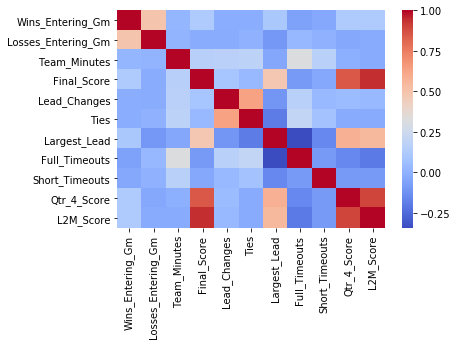

In [7]:
sb.heatmap(dfGameData.drop(columns=["Game_ID"]).corr(method='pearson'), cmap='coolwarm')

Lets keep it simple and make two linear regression models. One with all the variables, then one with selected "must watch" variables: Wins, Lead Changes, 4Q Scoring.

But first lets look if there are any easily discernable trends overall

/Users/MP/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/MP/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/MP/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

Text(0.25,0.9,u'Clear decline in viewership as season goes on')

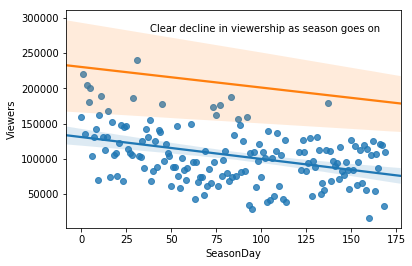

In [8]:
# Group By Season
seasons = pd.DataFrame(trainingSet.groupby(by=["Season","Game_Date"], as_index=False).sum())
viewers1617 = seasons[seasons["Season"] == "2016-17"]
viewers1718 = seasons[seasons["Season"] == "2017-18"]

# Create 'Day of Season' Variable
viewers1617["SeasonDay"] = viewers1617["Game_Date"] - min(viewers1617["Game_Date"])
viewers1718["SeasonDay"] = viewers1718["Game_Date"] - min(viewers1617["Game_Date"])
# Convert Time Deltas to Integer Values
viewers1617["SeasonDay"] = (viewers1617["SeasonDay"] / np.timedelta64(1, 'D')).astype(int)
viewers1718["SeasonDay"] = (viewers1718["SeasonDay"] / np.timedelta64(1, 'D')).astype(int)

# Plot
sb.regplot(x="SeasonDay", y="Viewers", data=viewers1617)
sb.regplot(x="SeasonDay", y="Viewers", data=viewers1718)

plt.annotate(s="Clear decline in viewership as season goes on", xycoords='axes fraction', xy=(0.25,0.90))

### Time to make a simple linear regression model, but first, make sure we create the right variables
We will focus on the following variables:
<ul>
<li>Day of Season
<li>Wins Entering Game
<li>Number of All-Stars in the Game
<li>Key Team     <em>Based on recent NBA Semifinalists</em>
    <ul><li>Golden State, Houston, Oklahoma City, San Antonio, Cleveland, Boston, Miami and Toronto</ul>
</ul>

<em>Because the games associated with the test set do not have game data like 'total scored' some of the easier to use variables are going to be unavailable</em>

<font color='red'>There are a number of other things that we could look into that would make the model more interesting, but for expediencies sake, this will be relatively straight forward. 
    <li> Predict specific countries based on if there are locally produced stars. 
    <li> Create a list of 'marquee players' that drive viwership beyond whether or not they are on an all star team.
    <li> Highlight 'holiday games' like Christmas Day matchups.
</font>

In [9]:
dfGameDataNoNA

,Season,Game_ID,Game_Date,Team,Location,Wins_Entering_Gm,Losses_Entering_Gm,Team_Minutes,Final_Score,Lead_Changes,Ties,Largest_Lead,Full_Timeouts,Short_Timeouts,Qtr_4_Score,L2M_Score
0,2016-17,21600001,2016-10-25,CLE,H,0,0,240.0,117.0,1.0,3.0,32.0,4.0,1.0,82.0,113.0
1,2016-17,21600001,2016-10-25,NYK,A,0,0,240.0,88.0,0.0,1.0,4.0,4.0,2.0,64.0,84.0
2,2016-17,21600002,2016-10-25,POR,H,0,0,240.0,113.0,6.0,6.0,13.0,5.0,0.0,77.0,104.0
3,2016-17,21600002,2016-10-25,UTA,A,0,0,240.0,104.0,5.0,1.0,8.0,5.0,2.0,83.0,102.0
4,2016-17,21600003,2016-10-25,GSW,H,0,0,240.0,100.0,1.0,2.0,4.0,3.0,1.0,77.0,100.0
5,2016-17,21600003,2016-10-25,SAS,A,0,0,240.0,129.0,1.0,1.0,29.0,5.0,1.0,97.0,122.0
6,2016-17,21600004,2016-10-26,MIA,A,0,0,240.0,108.0,7.0,6.0,19.0,4.0,1.0,80.0,104.0
7,2016-17,21600004,2016-10-26,ORL,H,0,0,240.0,96.0,7.0,7.0,7.0,4.0,2.0,69.0,92.0
8,2016-17,21600005,2016-10-26,DAL,A,0,0,265.0,121.0,2.0,7.0,1.0,7.0,4.0,85.0,110.0
9,2016-17,21600005,2016-10-26,IND,H,0,0,265.0,130.0,2.0,1.0,14.0,5.0,2.0,94.0,110.0


In [10]:
# Use Games where we have data, ignore "no data games" as this will be our "TrainingSet"
dfModelData = dfGameDataNoNA

# Create Away Team column 
dfModelData["AwayTeam"] = dfModelData.loc[:,"Team"].shift(-1)
# Get Integeger Variables as sums
dfModelDataSum = dfModelData.groupby(by="Game_ID").sum()
# Drop "Away Team" Row in original data
dfModelData = dfModelData[dfModelData["Location"] == "H"]
# Drop Columns that we will merge as sums
dfModelData.drop(inplace=True, axis=1, labels=["Location", "Wins_Entering_Gm", "Losses_Entering_Gm",
                         "Team_Minutes", "Final_Score",
                         "Lead_Changes", "Ties",
                         "Largest_Lead", "Full_Timeouts",
                         "Short_Timeouts", "Qtr_4_Score", "L2M_Score"])
# Merge the Sum Data
dfModelData = dfModelData.join(dfModelDataSum, on="Game_ID")


/Users/MP/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/MP/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [11]:
# Create Key Team Variable Column
key_teams = ["GSW", "HOU", "OKC", "SAS", "CLE", "MIA", "BOS", "TOR"]
# Using the outliers as seperate list
best_teams = ["GSW", "OKC", "CLE"]

def keyAdd(theTeam):
    if theTeam["Team"] in key_teams:
        return 1
    elif theTeam["AwayTeam"] in key_teams:
        return 1
    else:
        return 0

def bestAdd(theTeam):
    if theTeam["Team"] in best_teams:
        return 1
    elif theTeam["AwayTeam"] in best_teams:
        return 1
    else:
        return 0


dfModelData["KeyTeam"] = dfModelData.apply(keyAdd, axis=1)
dfModelData["BestTeam"] = dfModelData.apply(bestAdd, axis=1)

In [12]:
# Create Day of Season Variable
# Get first day of season for 2016-17 then 2017-18
dfModelData["FirstDay"] = 0
dfModelData["FirstDay"][dfModelData["Season"] == "2016-17"] = min(
    dfModelData["Game_Date"][dfModelData["Season"] == "2016-17"])
dfModelData["FirstDay"][dfModelData["Season"] == "2017-18"] = min(
    dfModelData["Game_Date"][dfModelData["Season"] == "2017-18"])

# Move FirstDay to datetime
dfModelData["FirstDay"] = pd.to_datetime(dfModelData["FirstDay"])

# Get TimeDelta
dfModelData["SeasonDay"] = dfModelData["Game_Date"] - dfModelData["FirstDay"]
# Convert to integer
dfModelData["SeasonDay"] = (dfModelData["SeasonDay"] /np.timedelta64(1,'D')).astype(int)
dfModelData.head()

/Users/MP/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/MP/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Season,Game_ID,Game_Date,Team,AwayTeam,Wins_Entering_Gm,Losses_Entering_Gm,Team_Minutes,Final_Score,Lead_Changes,Ties,Largest_Lead,Full_Timeouts,Short_Timeouts,Qtr_4_Score,L2M_Score,KeyTeam,BestTeam,FirstDay,SeasonDay
0,2016-17,21600001,2016-10-25,CLE,NYK,0,0,480.0,205.0,1.0,4.0,36.0,8.0,3.0,146.0,197.0,1,1,2016-10-25,0
2,2016-17,21600002,2016-10-25,POR,UTA,0,0,480.0,217.0,11.0,7.0,21.0,10.0,2.0,160.0,206.0,0,0,2016-10-25,0
4,2016-17,21600003,2016-10-25,GSW,SAS,0,0,480.0,229.0,2.0,3.0,33.0,8.0,2.0,174.0,222.0,1,1,2016-10-25,0
7,2016-17,21600004,2016-10-26,ORL,DAL,0,0,480.0,204.0,14.0,13.0,26.0,8.0,3.0,149.0,196.0,0,0,2016-10-25,1
9,2016-17,21600005,2016-10-26,IND,BOS,0,0,530.0,251.0,4.0,8.0,15.0,12.0,6.0,179.0,220.0,1,0,2016-10-25,1


In [13]:
# Get number of All Stars per game
dfAllStars = playerData[playerData["ASG_Team"] != "None"]
# Group by Game and limit to ASG_Team
dfAllStars = dfAllStars.groupby(by="Game_ID", as_index=False).count()
# Drop All other columns
dfAllStars = dfAllStars[["Game_ID","ASG_Team"]]
# Join on Model Data
dfModelData = dfModelData.merge(dfAllStars, on="Game_ID")

In [14]:
# Remove Columns we will not be using
dfModelData.drop(labels=["Season", "Team_Minutes", 
                         "Final_Score", "Lead_Changes", 
                         "Ties", "Largest_Lead",
                         "Full_Timeouts", "Short_Timeouts",
                         "Qtr_4_Score","L2M_Score",
                         "FirstDay", "Team", "AwayTeam","Losses_Entering_Gm"], 
                         inplace=True, axis=1)

In [15]:
# Add Total Viewers to this dataframe
viewers = pd.DataFrame(trainingSet.groupby(by="Game_ID").sum())
dfModelData = dfModelData.join(viewers, on="Game_ID")

#### Now that we've got our variables set, lets start a linear regression model

In [16]:
def OLSModel(y, X):
    # Create Model
    model = sm.OLS(y, X)
    results = model.fit()
    dfResults = pd.DataFrame(results.predict(), columns=["PredViewers"])
    dfResults["Actual"] = y
    dfResults["Error"] = abs(dfResults["Actual"] - dfResults["PredViewers"])
    dfResults["percError"] = abs(dfResults["Error"] / dfResults["Actual"])
    # Calculate MAPE using Arithmetic
    mpMSE = dfResults["percError"].sum() / len(dfResults["Actual"])
    print(results.summary())
    print("MAPE is: %f" % mpMSE)

In [17]:
# Add Constant Column
X = dfModelData[["Wins_Entering_Gm", "KeyTeam", "SeasonDay", "ASG_Team"]]
X = sm.add_constant(X)
y = dfModelData["Viewers"]
OLSModel(y, X)
print("This doesn't look very good, let's try normalizing some data")

                            OLS Regression Results                            
Dep. Variable:                Viewers   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     333.4
Date:                Tue, 10 Jul 2018   Prob (F-statistic):          3.15e-212
Time:                        23:31:50   Log-Likelihood:                -17920.
No. Observations:                1715   AIC:                         3.585e+04
Df Residuals:                    1710   BIC:                         3.588e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.136e+04    587.097  

In [18]:
dfNormalized = dfModelData
# Replace NA's with 0's
dfNormalized.fillna(value=0, inplace=True)
# Take log of Wins
dfNormalized["Wins_Entering_Gm"] = np.log(dfNormalized["Wins_Entering_Gm"] + 1)
# Find Percent of Season Done
dfNormalized["SeasonDay"] = dfNormalized["SeasonDay"] / max(dfNormalized["SeasonDay"])

# Create Model
X = dfNormalized[["Wins_Entering_Gm", "KeyTeam", "SeasonDay", "ASG_Team"]]
X = sm.add_constant(X)
y = dfModelData["Viewers"]
OLSModel(y, X)

print("This also looks bad, lets maybe log out the results")

                            OLS Regression Results                            
Dep. Variable:                Viewers   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     342.1
Date:                Tue, 10 Jul 2018   Prob (F-statistic):          1.93e-216
Time:                        23:31:50   Log-Likelihood:                -17910.
No. Observations:                1715   AIC:                         3.583e+04
Df Residuals:                    1710   BIC:                         3.586e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.578e+04    990.570  

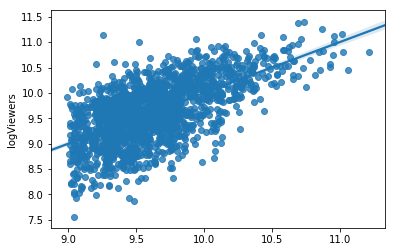

In [23]:
dfLogged = dfModelData
# Replace NA's with 0's
dfLogged.fillna(value=1, inplace=True)
# Take log of Wins
dfLogged["logViewers"] = np.log(dfLogged["Viewers"])
# Find Percent of Season Done
dfLogged["SeasonDay"] = dfLogged["SeasonDay"] / max(dfLogged["SeasonDay"])

# Create Model
X = dfLogged[["Wins_Entering_Gm", "KeyTeam", "SeasonDay", "ASG_Team"]]
X = sm.add_constant(X)
y = dfLogged["logViewers"]

model = sm.OLS(y, X, hasconst=True)
results = model.fit()
sb.regplot(x=results.predict(), y=y, order=1)

In [24]:
# Lets exponentiate and find MAPE
dfLogged["Predict"] = np.e ** results.predict()
dfLogged["Error"] = abs((dfLogged["Viewers"] - dfLogged["Predict"])
                        / dfLogged["Viewers"])
MAPE = dfLogged["Error"].sum() / len(dfLogged["Error"])
print(MAPE)

0.412493506986041
